In [1]:
import os
import pandas as pd
import numpy as np
import preprocess_data as prep
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

DATA_PATH = '../cell-profiler/measurements'
FILENAME = 'Biomarkers_Cells.csv'

## Load and parse the data

In [2]:
biomarkers = prep.cell_data(data_path=DATA_PATH, cytoplasm=False, biomarkers=True)

The are no repeated column names: True


In [3]:
print(biomarkers.shape)
list(biomarkers.columns)

(612, 157)


['label',
 'image',
 'object',
 'combination',
 'site',
 'stiffness',
 'well',
 'integratedintensityedge_ker',
 'integratedintensityedge_vim',
 'integratedintensity_ker',
 'integratedintensity_vim',
 'lowerquartileintensity_ker',
 'lowerquartileintensity_vim',
 'madintensity_ker',
 'madintensity_vim',
 'massdisplacement_ker',
 'massdisplacement_vim',
 'maxintensityedge_ker',
 'maxintensityedge_vim',
 'maxintensity_ker',
 'maxintensity_vim',
 'meanintensityedge_ker',
 'meanintensityedge_vim',
 'meanintensity_ker',
 'meanintensity_vim',
 'medianintensity_ker',
 'medianintensity_vim',
 'minintensityedge_ker',
 'minintensityedge_vim',
 'minintensity_ker',
 'minintensity_vim',
 'stdintensityedge_ker',
 'stdintensityedge_vim',
 'stdintensity_ker',
 'stdintensity_vim',
 'upperquartileintensity_ker',
 'upperquartileintensity_vim',
 'loc_centermassintensityX_ker',
 'loc_centermassintensityX_vim',
 'loc_centermassintensityY_ker',
 'loc_centermassintensityY_vim',
 'loc_centermassintensityZ_ker',


### Cells per stiffness

In [4]:
biomarkers.groupby('stiffness')[['label']].count()

,label
stiffness,
0.2,83
0.5,78
2.0,164
8.0,49
16.0,97
32.0,55
64.0,86


## Clean the data

### Missing values?

In [5]:
biomarkers.isnull().sum().sum()

0

### Descriptive statistics

In [6]:
stats = biomarkers.describe()

In [7]:
pd.options.display.max_columns = biomarkers.shape[1]
stats

,integratedintensityedge_ker,integratedintensityedge_vim,integratedintensity_ker,integratedintensity_vim,lowerquartileintensity_ker,lowerquartileintensity_vim,madintensity_ker,madintensity_vim,massdisplacement_ker,massdisplacement_vim,maxintensityedge_ker,maxintensityedge_vim,maxintensity_ker,maxintensity_vim,meanintensityedge_ker,meanintensityedge_vim,meanintensity_ker,meanintensity_vim,medianintensity_ker,medianintensity_vim,minintensityedge_ker,minintensityedge_vim,minintensity_ker,minintensity_vim,stdintensityedge_ker,stdintensityedge_vim,stdintensity_ker,stdintensity_vim,upperquartileintensity_ker,upperquartileintensity_vim,loc_centermassintensityX_ker,loc_centermassintensityX_vim,loc_centermassintensityY_ker,loc_centermassintensityY_vim,loc_centermassintensityZ_ker,loc_centermassintensityZ_vim,loc_centerX,loc_centerY,loc_centerZ,loc_maxintensityX_ker,loc_maxintensityX_vim,loc_maxintensityY_ker,loc_maxintensityY_vim,loc_maxintensityZ_ker,loc_maxintensityZ_vim,number_object_number,angularsecondmoment_ker_00,angularsecondmoment_ker_01,angularsecondmoment_ker_02,angularsecondmoment_ker_03,angularsecondmoment_vim_00,angularsecondmoment_vim_01,angularsecondmoment_vim_02,angularsecondmoment_vim_03,contrast_ker_00,contrast_ker_01,contrast_ker_02,contrast_ker_03,contrast_vim_00,contrast_vim_01,contrast_vim_02,contrast_vim_03,correlation_ker_00,correlation_ker_01,correlation_ker_02,correlation_ker_03,correlation_vim_00,correlation_vim_01,correlation_vim_02,correlation_vim_03,differenceentropy_ker_00,differenceentropy_ker_01,differenceentropy_ker_02,differenceentropy_ker_03,differenceentropy_vim_00,differenceentropy_vim_01,differenceentropy_vim_02,differenceentropy_vim_03,differencevariance_ker_00,differencevariance_ker_01,differencevariance_ker_02,differencevariance_ker_03,differencevariance_vim_00,differencevariance_vim_01,differencevariance_vim_02,differencevariance_vim_03,entropy_ker_00,entropy_ker_01,entropy_ker_02,entropy_ker_03,entropy_vim_00,entropy_vim_01,entropy_vim_02,entropy_vim_03,infomeas1_ker_00,infomeas1_ker_01,infomeas1_ker_02,infomeas1_ker_03,infomeas1_vim_00,infomeas1_vim_01,infomeas1_vim_02,infomeas1_vim_03,infomeas2_ker_00,infomeas2_ker_01,infomeas2_ker_02,infomeas2_ker_03,infomeas2_vim_00,infomeas2_vim_01,infomeas2_vim_02,infomeas2_vim_03,inversedifferencemoment_ker_00,inversedifferencemoment_ker_01,inversedifferencemoment_ker_02,inversedifferencemoment_ker_03,inversedifferencemoment_vim_00,inversedifferencemoment_vim_01,inversedifferencemoment_vim_02,inversedifferencemoment_vim_03,sumaverage_ker_00,sumaverage_ker_01,sumaverage_ker_02,sumaverage_ker_03,sumaverage_vim_00,sumaverage_vim_01,sumaverage_vim_02,sumaverage_vim_03,sumentropy_ker_00,sumentropy_ker_01,sumentropy_ker_02,sumentropy_ker_03,sumentropy_vim_00,sumentropy_vim_01,sumentropy_vim_02,sumentropy_vim_03,sumvariance_ker_00,sumvariance_ker_01,sumvariance_ker_02,sumvariance_ker_03,sumvariance_vim_00,sumvariance_vim_01,sumvariance_vim_02,sumvariance_vim_03,variance_ker_00,variance_ker_01,variance_ker_02,variance_ker_03,variance_vim_00,variance_vim_01,variance_vim_02,variance_vim_03
count,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.0,612.0,612.000000,612.000000,612.0,612.000000,612.000000,612.000000,612.000000,612.0,612.0,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.0

In [8]:
biomarkers.describe(include=['object'])

,label,image,object,combination,site,well
count,612,612,612,612,612,612
unique,612,73,18,1,7,3
top,64.0-B-A1-2-3,40,1,B,2,A1
freq,1,18,73,612,143,265


### Drop features with zero variance

In [9]:
list(stats.columns[stats.loc['std', :] == 0])

['loc_centermassintensityZ_ker',
 'loc_centermassintensityZ_vim',
 'loc_centerZ',
 'loc_maxintensityZ_ker',
 'loc_maxintensityZ_vim']

In [10]:
biomarkers.drop(stats.columns[stats.loc['std', :] == 0], axis=1, inplace=True)

### Drop duplicates

In [11]:
dupl_cols = ['number_object_number']
[biomarkers.drop([col], axis=1, inplace=True) for col in dupl_cols if sum(biomarkers.object.astype(int) != biomarkers[col])==0]

[None]

In [12]:
print("The dataset after cleaning has {} rows and {} columns.".format(biomarkers.shape[0], biomarkers.shape[1]))
biomarkers.dtypes.value_counts()

The dataset after cleaning has 612 rows and 151 columns.


float64     144
object        6
category      1
dtype: int64

### Define feature columns

In [13]:
biomarkers_ = biomarkers.copy()
biomarkers_['stiffness_num'] = pd.to_numeric(biomarkers_.stiffness)

In [14]:
numeric_cols = biomarkers_.select_dtypes(include=[np.number]).columns
feature_cols = biomarkers_.select_dtypes(include=[np.number]).drop(['stiffness_num'], axis=1).columns

## Explore the data

### Mean intensity

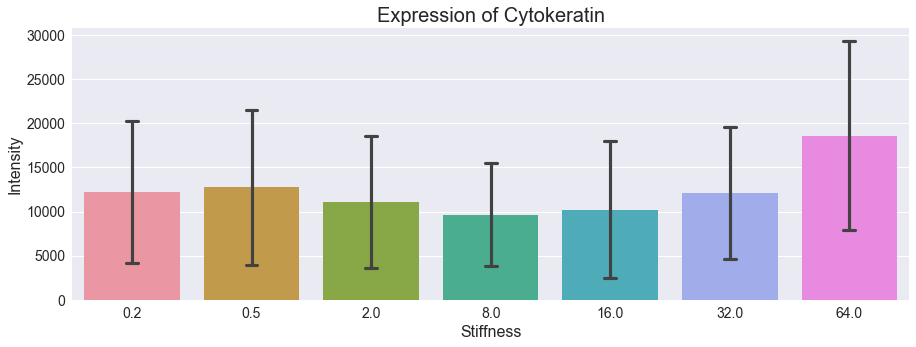

In [15]:
sns.barplot(x=biomarkers.stiffness, y=biomarkers.meanintensity_ker * 65535,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Expression of Cytokeratin")
plt.savefig('../results/Ker Intensity.png', bbox_inches='tight', dpi=300);

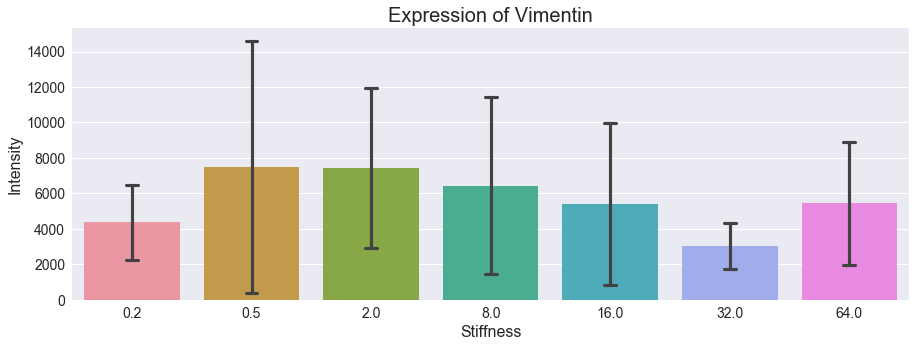

In [17]:
sns.barplot(x=biomarkers.stiffness, y=biomarkers.meanintensity_vim * 65535,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Expression of Vimentin")
plt.savefig('../results/Vim Intensity.png', bbox_inches='tight', dpi=300);

### Cytokeratin to Vimentin ratio

In [19]:
biomarkers['ratio'] = biomarkers.meanintensity_ker / biomarkers.meanintensity_vim

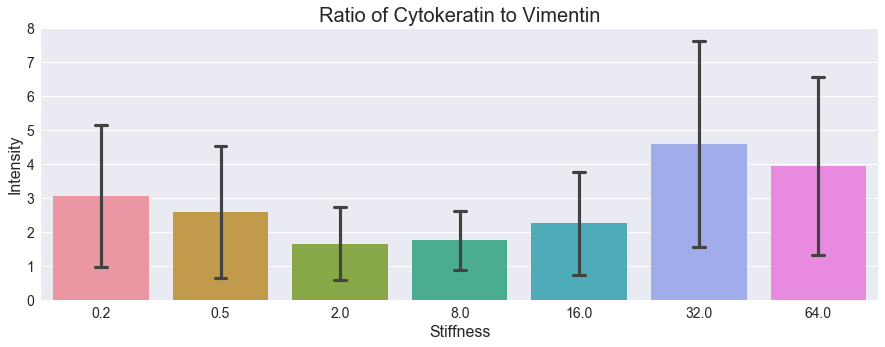

In [20]:
sns.barplot(x=biomarkers.stiffness, y=biomarkers.ratio,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Ratio of Cytokeratin to Vimentin");
plt.savefig('../results/Ker to Vim ratio.png', bbox_inches='tight', dpi=300);

### Normalise intensity by gain

#### Load metadata

###### Keratin

In [21]:
DATA_PATH = '../datasets/'

In [22]:
ker_meta = prep.load_data("Ker_metadata.csv", data_path=DATA_PATH)
ker_meta.rename(str.lower, axis='columns', inplace=True)
ker_meta = prep.create_label(ker_meta, per_cell=False)
print(ker_meta.shape)
ker_meta.head()

(177, 15)


,stiffness,combination,well,site,channel,fluorophore,gain,offset,power,attenuation,pcf,zposition,zoffset,user,label
0,0.2,B,A1,1,1,AF647,700,0,0.005,0.95,7679.330711,795.356,0.003333,44709390,0.2-B-A1-1
1,0.2,B,A1,2,1,AF647,700,0,0.005,0.95,7679.330711,795.272,0.003332,44709390,0.2-B-A1-2
2,0.2,B,A1,3,1,AF647,700,0,0.005,0.95,7679.330711,793.206,0.003330,44709390,0.2-B-A1-3
3,0.2,B,A1,4,1,AF647,700,0,0.005,0.95,7679.330711,793.972,0.003331,44709390,0.2-B-A1-4
4,0.2,B,A1,5,1,AF647,700,0,0.005,0.95,7679.330711,790.734,0.003328,44709390,0.2-B-A1-5


In [23]:
ker_meta.groupby('stiffness').gain.value_counts()

stiffness  gain
0.2        700     30
0.5        700     15
2.0        700     31
8.0        950     23
16.0       730     16
           780     11
           950      1
32.0       780     19
64.0       700     14
           730     10
           690      6
           780      1
Name: gain, dtype: int64

###### Vimentin

In [24]:
vim_meta = prep.load_data("Vim_metadata.csv", data_path=DATA_PATH)
vim_meta.rename(str.lower, axis='columns', inplace=True)
vim_meta = prep.create_label(vim_meta, per_cell=False)
print(vim_meta.shape)
vim_meta.head()

(175, 15)


,stiffness,combination,well,site,channel,fluorophore,gain,offset,power,attenuation,pcf,zposition,zoffset,user,label
0,0.2,B,A1,1,2,AF568,680,0,0.02,0.95,7679.330711,795.356,0.003333,44709390,0.2-B-A1-1
1,0.2,B,A1,2,2,AF568,680,0,0.02,0.95,7679.330711,795.272,0.003332,44709390,0.2-B-A1-2
2,0.2,B,A1,3,2,AF568,680,0,0.02,0.95,7679.330711,793.206,0.003330,44709390,0.2-B-A1-3
3,0.2,B,A1,4,2,AF568,680,0,0.02,0.95,7679.330711,793.972,0.003331,44709390,0.2-B-A1-4
4,0.2,B,A1,5,2,AF568,680,0,0.02,0.95,7679.330711,790.734,0.003328,44709390,0.2-B-A1-5


In [25]:
vim_meta.groupby('stiffness').gain.value_counts()

stiffness  gain
0.2        680     30
0.5        650     15
2.0        680     16
           650     15
8.0        801     21
16.0       680     27
           801      1
32.0       680     19
64.0       680     19
           650     12
Name: gain, dtype: int64

#### Merge datasets

In [26]:
common_columns = ['stiffness', 'combination', 'well', 'site']
gain = pd.merge(ker_meta[['gain', 'stiffness', 'combination', 'well', 'site']], 
                vim_meta[['gain', 'stiffness', 'combination', 'well', 'site']], 
                how='left', on=common_columns,  
                suffixes=('_ker', '_vim'))
gain.head(3)

,gain_ker,stiffness,combination,well,site,gain_vim
0,700,0.2,B,A1,1,680.0
1,700,0.2,B,A1,2,680.0
2,700,0.2,B,A1,3,680.0


In [27]:
intensity = pd.merge(biomarkers[['label', 'stiffness', 'combination', 'well', 'site', 
                                 'meanintensity_ker', 'meanintensity_vim']], 
                     gain, how='left', on=common_columns)
intensity.head(3)

,label,stiffness,combination,well,site,meanintensity_ker,meanintensity_vim,gain_ker,gain_vim
0,0.2-B-A1-1-1,0.2,B,A1,1,0.047023,0.047942,700,680.0
1,0.2-B-A1-1-2,0.2,B,A1,1,0.136760,0.076530,700,680.0
2,0.2-B-A1-1-3,0.2,B,A1,1,0.211328,0.041861,700,680.0


In [28]:
intensity.meanintensity_ker = intensity.meanintensity_ker * 65535
intensity.meanintensity_vim = intensity.meanintensity_vim * 65535

#### Divide by gain

In [29]:
intensity['normintensity_ker'] = intensity.meanintensity_ker / intensity.gain_ker
intensity['normintensity_vim'] = intensity.meanintensity_vim / intensity.gain_vim

intensity.head(3)

,label,stiffness,combination,well,site,meanintensity_ker,meanintensity_vim,gain_ker,gain_vim,normintensity_ker,normintensity_vim
0,0.2-B-A1-1-1,0.2,B,A1,1,3081.630381,3141.900959,700,680.0,4.402329,4.620443
1,0.2-B-A1-1-2,0.2,B,A1,1,8962.543099,5015.380655,700,680.0,12.803633,7.375560
2,0.2-B-A1-1-3,0.2,B,A1,1,13849.366754,2743.339708,700,680.0,19.784810,4.034323


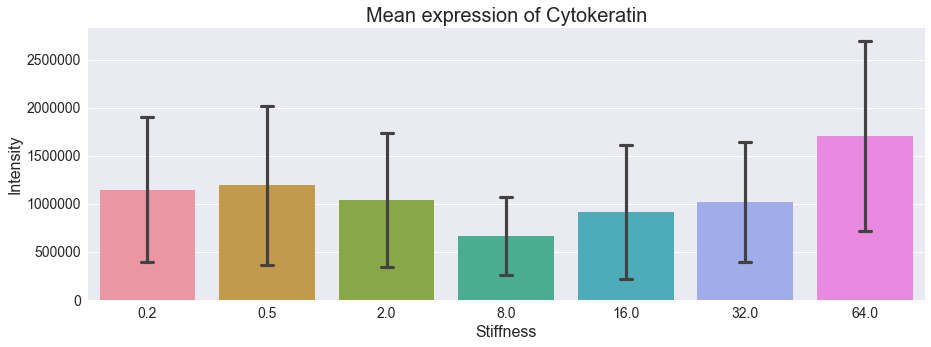

In [35]:
sns.barplot(x=intensity.stiffness, y=intensity.normintensity_ker * 65535,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Mean expression of Cytokeratin")
plt.savefig('../results/Ker Mean Intensity by Gain.png', bbox_inches='tight', dpi=300);

Text(0.5, 1.0, 'Median expression of Cytokeratin')

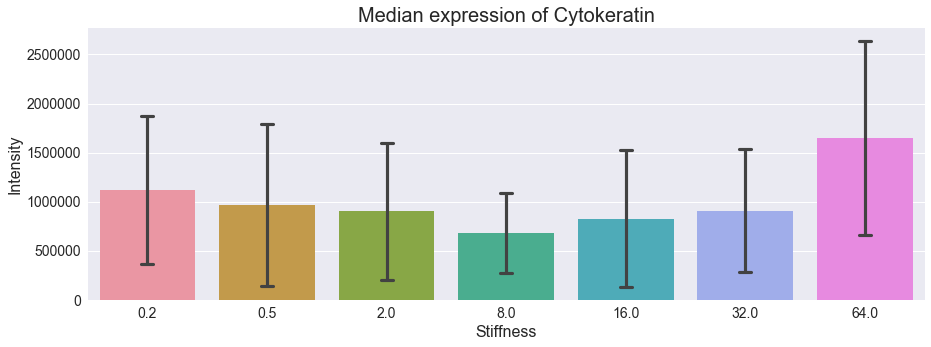

In [36]:
sns.barplot(x=intensity.stiffness, y=intensity.normintensity_ker * 65535,
            ci='sd', estimator=np.median, capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Median expression of Cytokeratin")

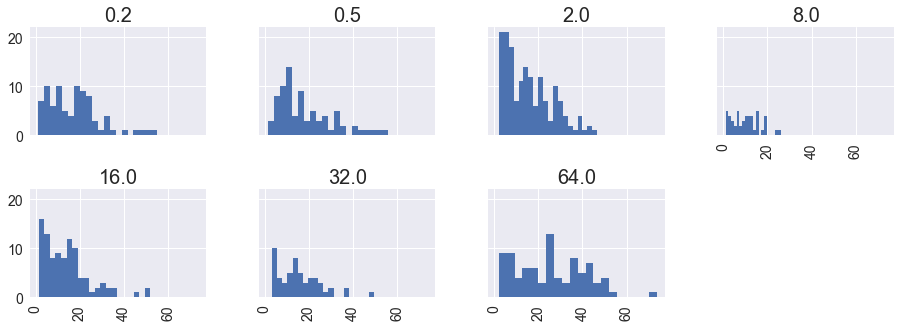

In [32]:
intensity.hist(column='normintensity_ker', by='stiffness', sharex=True, sharey=True, layout=(2, 4), bins=20);

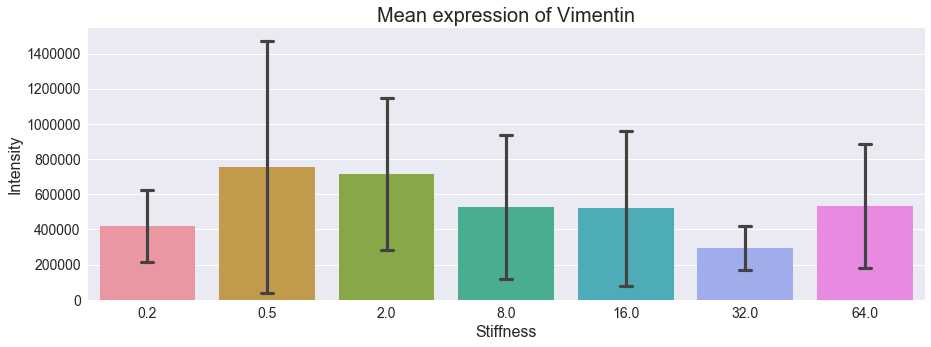

In [37]:
sns.barplot(x=intensity.stiffness, y=intensity.normintensity_vim * 65535,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Mean expression of Vimentin")
plt.savefig('../results/Vim Mean Intensity by Gain.png', bbox_inches='tight', dpi=300);

Text(0.5, 1.0, 'Median expression of Vimentin')

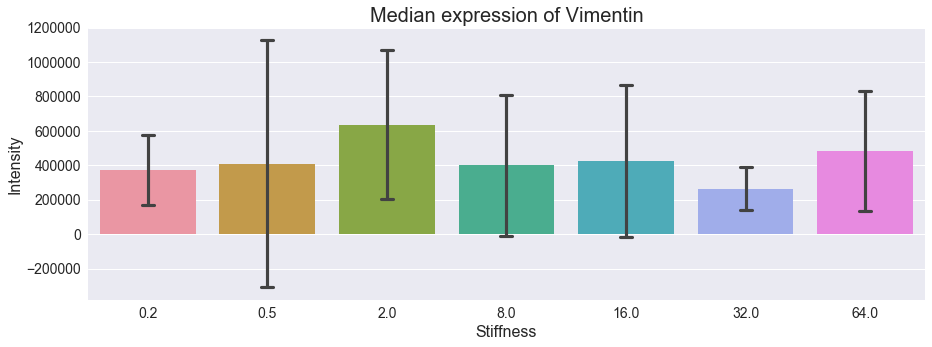

In [38]:
sns.barplot(x=intensity.stiffness, y=intensity.normintensity_vim * 65535,
            ci='sd', estimator=np.median, capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Median expression of Vimentin")

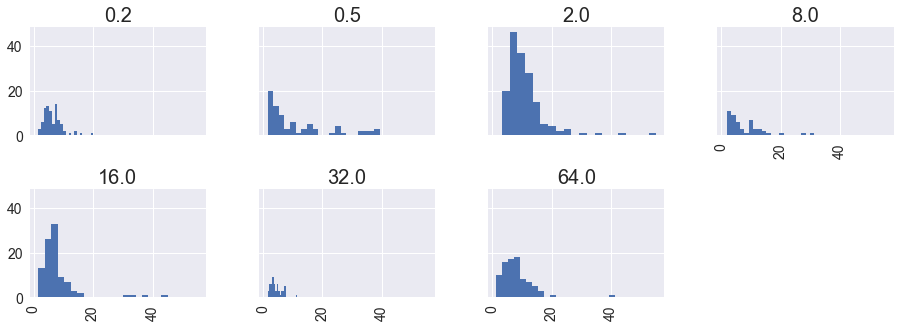

In [33]:
intensity.hist(column='normintensity_vim', by='stiffness', sharex=True, sharey=True, layout=(2, 4), bins=20);

### Ratio of normalised signals

In [ ]:
intensity['norm_ratio'] = intensity.normintensity_ker / intensity.normintensity_vim

#### Histograms

In [ ]:
intensity.norm_ratio.hist(bins = 100);
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of Cytokeratin to Vimentin Ratio");
plt.savefig('../results/Ker to Vim ratio hist.png', bbox_inches='tight', dpi=300);

In [ ]:
intensity.hist(column='norm_ratio', by='stiffness', sharex=True, sharey=True, layout=(2, 4));

In [ ]:
intensity[intensity.stiffness=="32.0"].hist(column='norm_ratio', bins=50);

#### Barplot of ratio by stiffness

In [ ]:
sns.barplot(x=intensity.stiffness, y=intensity.norm_ratio,
            ci='sd', capsize=.1);
plt.xlabel("Stiffness")
plt.ylabel("Intensity")
plt.title("Ratio of Cytokeratin to Vimentin");
plt.savefig('../results/Ker to Vim ratio by Gain.png', bbox_inches='tight', dpi=300);

#### Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = np.array(pd.to_numeric(intensity.stiffness))
y = intensity.norm_ratio

X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

X_train = X_train.reshape((-1, 1))
X_test = X_test.reshape((-1, 1))

X_train.shape, X_test.shape

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
y_pred = lin_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

#### Polynomial regression

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

X_train_poly.shape, X_test_poly.shape

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
y_pred = lin_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

In [ ]:
stiffness = [0.2, 0.5, 2.0, 8.0, 16.0, 32.0, 64.0]

#### K-Means

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

#X = np.array(intensity.norm_ratio).reshape((-1, 1))
X = np.array(intensity[['normintensity_ker', 'normintensity_vim']])

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

In [ ]:
intensity['cluster'] = km.labels_
km.labels_

In [ ]:
# Group by clusters and calculate the mean of each feature.
intensity.groupby('cluster').mean()

In [ ]:
sns.scatterplot(data=intensity, x='normintensity_ker', y='normintensity_vim', 
                hue='stiffness', palette=sns.color_palette("husl", 7), s=100);
plt.xlim(0, 70)
plt.ylim(0, 70)

In [ ]:
pd.crosstab(intensity.stiffness, intensity.cluster)

### Statistical testing

#### Check parametric assumptions

In [ ]:
biomarkers.hist(column='meanintensity_ker', by='stiffness');

In [ ]:
biomarkers.groupby("stiffness").meanintensity_ker.describe()

In [ ]:
biomarkers.hist(column='meanintensity_vim', by='stiffness');

In [ ]:
biomarkers.groupby("stiffness").meanintensity_vim.describe()

#### Two-sample t-test

###### Keratin

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind

print("Background in keratin channel:\n")

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "0.2"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "2.0"].meanintensity_ker)
print("0.2 kPa vs 2.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "2.0"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "16.0"].meanintensity_ker)
print("2.0 kPa vs 16.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "16.0"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "32.0"].meanintensity_ker)
print("16.0 kPa vs 32.0 kPa \t p-value =", p)
      
t, p = ttest_ind(biomarkers[biomarkers.stiffness == "32.0"].meanintensity_ker,
                 biomarkers[biomarkers.stiffness == "64.0"].meanintensity_ker, 
                 equal_var=False)
print("32.0 kPa vs 64.0 kPa \t p-value =", p)

###### Vimentin

In [ ]:
print("Intensity in vimentin channel:\n")

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "0.2"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "2.0"].meanintensity_vim, 
                 equal_var=False)
print("0.2 kPa vs 2.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "2.0"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "16.0"].meanintensity_vim, 
                 equal_var=False)
print("2.0 kPa vs 16.0 kPa \t p-value =", p)

t, p = ttest_ind(biomarkers[biomarkers.stiffness == "16.0"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "32.0"].meanintensity_vim, 
                 equal_var=False)
print("16.0 kPa vs 32.0 kPa \t p-value =", p)
      
t, p = ttest_ind(biomarkers[biomarkers.stiffness == "32.0"].meanintensity_vim,
                 biomarkers[biomarkers.stiffness == "64.0"].meanintensity_vim, 
                 equal_var=False)
print("32.0 kPa vs 64.0 kPa \t p-value =", p)

## Create dataframes for Keratin and Vimentin

In [ ]:
channels = ['ker', 'vim']
keratin, vimentin = prep.split_dataset(biomarkers_, channels=channels)

In [ ]:
print(keratin.shape, vimentin.shape)

## Correlations between features

### Keratin

In [ ]:
keratin_ = keratin.copy()
keratin_['stiffness_num'] = pd.to_numeric(keratin_.stiffness)

In [ ]:
correlations = keratin_.corr();

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)

sns.heatmap(correlations, cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

plt.savefig('../results/Keratin Correlations.png', bbox_inches='tight', dpi=300);

In [ ]:
correlations.stiffness_num

### Vimentin

In [ ]:
vimentin_ = vimentin.copy()
vimentin_['stiffness_num'] = pd.to_numeric(vimentin_.stiffness)

In [ ]:
correlations = vimentin_.corr();

In [ ]:
plt.rcParams['figure.figsize'] = (12, 10)

sns.heatmap(correlations, cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

plt.savefig('../results/Vimentin Correlations.png', bbox_inches='tight', dpi=300);

In [ ]:
correlations.stiffness_num

## Explore groups of features

### Keratin

In [ ]:
list(keratin_.columns)

###### Intensity

In [ ]:
intensity = pd.concat([keratin_.loc[:, 'integratedintensityedge' : 'stdintensity'], keratin_.stiffness_num], axis=1) 
print(intensity.shape)

In [ ]:
# Transformations
group['log_majoraxislength_cell'] = np.log(group['majoraxislength_cell'])
#group['log_eccentricity_cell'] = np.log(group['eccentricity_cell'])
group['majoraxislength_cell'].hist();

In [ ]:
sns.heatmap(intensity.corr(), cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

In [ ]:
edge_intensity = intensity[[col for col in group.columns if 'edge' in col]]
edge_intensity.head()

In [ ]:
sns.heatmap(edge_intensity.corr(), annot=True, cmap=sns.color_palette("PRGn_r", 100), vmin=-1, vmax=1);

In [ ]:
sns.pairplot(edge_intensity, height=3);

## Clustering

### K-Means

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

X = biomarkers_[feature_cols]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

In [ ]:
# Review cluster labels.
km.labels_

In [ ]:
#Save the cluster labels and sort by cluster.
biomarkers_['cluster'] = km.labels_
biomarkers_.sort_values('cluster')

In [ ]:
# Review the custer centers.
km.cluster_centers_.shape

In [ ]:
# Group by clusters and calculate the mean of each feature.
biomarkers_.groupby('cluster').mean()

In [ ]:
# Save the `DataFrame` of cluster centroids.
centroids = biomarkers_.groupby('cluster').mean()

In [ ]:
colors = sns.color_palette("husl", 5)

sns.scatterplot(data=biomarkers_, x='meanintensityedge_origker', y='meanintensityedge_origvim', 
                s=100, hue='stiffness_num', palette=colors);

In [ ]:
colors = sns.color_palette("husl", 3)

sns.scatterplot(data=biomarkers_, x='meanintensityedge_origker', y='meanintensityedge_origvim', 
                s=100, hue='cluster', palette=colors);

sns.scatterplot(data=centroids, x='meanintensityedge_origker', y='meanintensityedge_origvim', 
                linewidth=3, marker='x', 
                s=200, color='black');

In [ ]:
pd.crosstab(biomarkers_.stiffness_num, biomarkers_.cluster)

### DBSCAN

In [ ]:
X = biomarkers_[feature_cols]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
db = DBSCAN(eps=0.001, min_samples=3)
db.fit(X_scaled)

In [ ]:
# Review the cluster labels.
db.labels_

### Agglomerative clustering

In [ ]:
biomarkers_norm = biomarkers_.copy()
# Standardise the entire dataset
biomarkers_norm[feature_cols] = (biomarkers_norm[feature_cols] - biomarkers_norm[feature_cols].mean()) / biomarkers_norm[feature_cols].std()

In [ ]:
# Prepare a vector of colours mapped to the 'stiffness' column
my_palette = dict(zip(biomarkers_norm.stiffness.unique(), sns.color_palette("Set3", 5)))
row_colors = biomarkers_norm.stiffness.map(my_palette)

print(my_palette.keys())
sns.palplot(my_palette.values())

In [ ]:
sns.clustermap(biomarkers_norm[feature_cols], 
               metric='euclidean', method='ward', 
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True, 
               row_colors=row_colors);

#plt.savefig('../results/Clustering.png', bbox_inches='tight', dpi=300);

## Intensity by stiffness

### Keratin

In [ ]:
keratin['total_px'] = keratin['Intensity_IntegratedIntensity_OrigKer'] / keratin['Intensity_MeanIntensity_OrigKer']
keratin['edge_px'] = keratin['Intensity_IntegratedIntensityEdge_OrigKer'] / keratin['Intensity_MeanIntensityEdge_OrigKer']

In [ ]:
keratin.head(3)

In [ ]:
keratin['IntegratedIntensityInner'] = keratin['Intensity_IntegratedIntensity_OrigKer'] - keratin['Intensity_IntegratedIntensityEdge_OrigKer']

keratin['MeanIntensityInner'] = keratin['IntegratedIntensityInner'] / (keratin['total_px'] - keratin['edge_px'])

In [ ]:
intensity_cols = ['Intensity_IntegratedIntensity_OrigKer', 
                  'IntegratedIntensityInner', 
                  'Intensity_IntegratedIntensityEdge_OrigKer']

fig, ax = plt.subplots()
keratin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Integrated intensity of Cytokeratin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Integrated Intensity", "Integrated Inner Intensity", "Integrated Edge Intensity"], fontsize=14);

In [ ]:
intensity_cols = ['Intensity_MeanIntensity_OrigKer', 
                  'MeanIntensityInner', 
                  'Intensity_MeanIntensityEdge_OrigKer']

fig, ax = plt.subplots()
keratin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Mean intensity of Cytokeratin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Mean Intensity", "Mean Inner Intensity", "Mean Edge Intensity"], fontsize=14);

plt.savefig('../results/Cytokeratin Mean Intensity.png', bbox_inches='tight', dpi=300);

### Vimentin

In [ ]:
vimentin['total_px'] = vimentin['Intensity_IntegratedIntensity_OrigVim'] / vimentin['Intensity_MeanIntensity_OrigVim']
vimentin['edge_px'] = vimentin['Intensity_IntegratedIntensityEdge_OrigVim'] / vimentin['Intensity_MeanIntensityEdge_OrigVim']

In [ ]:
vimentin.head(3)

In [ ]:
vimentin['IntegratedIntensityInner'] = vimentin['Intensity_IntegratedIntensity_OrigVim'] - vimentin['Intensity_IntegratedIntensityEdge_OrigVim']

vimentin['MeanIntensityInner'] = vimentin['IntegratedIntensityInner'] / (vimentin['total_px'] - vimentin['edge_px'])

In [ ]:
intensity_cols = ['Intensity_IntegratedIntensity_OrigVim', 
                  'IntegratedIntensityInner', 
                  'Intensity_IntegratedIntensityEdge_OrigVim']

fig, ax = plt.subplots()
vimentin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Integrated intensity of Vimentin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Integrated Intensity", "Integrated Inner Intensity", "Integrated Edge Intensity"], fontsize=14);

In [ ]:
intensity_cols = ['Intensity_MeanIntensity_OrigVim', 
                  'MeanIntensityInner', 
                  'Intensity_MeanIntensityEdge_OrigVim']

fig, ax = plt.subplots()
vimentin.groupby('stiffness')[intensity_cols].mean().plot(kind='bar', 
                                                         title="Mean intensity of Vimentin", 
                                                         fontsize=14,
                                                         ax=ax);
ax.legend(["Mean Intensity", "Mean Inner Intensity", "Mean Edge Intensity"], fontsize=14);

plt.savefig('../results/Vimentin Mean Intensity.png', bbox_inches='tight', dpi=300);

## Normalise signal and compare

In [ ]:
max_ker = keratin[['Intensity_MeanIntensity_OrigKer']].max()
max_ker

In [ ]:
keratin[['Intensity_MeanIntensity_OrigKer']].head()